## Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

## Import Data

In [2]:
# Load the data
df = pd.read_csv('Data/data.csv', skiprows=4)

# Fill in missing park names and drop 'Annual Total' column
df['Park_Name'] = df['Park_Name'].ffill()
df = df.drop(columns=['Annual Total'])

print("Original data shape:", df.shape)
print(df.head())

Original data shape: (369, 14)
                 Park_Name  Year January February  March  April    May   June  \
0  A L Burruss Nature Park  2025   1,400    1,900  2,200  2,500  2,600  1,900   
1  A L Burruss Nature Park  2024   1,500    1,700  1,500    206  1,200  3,200   
2  A L Burruss Nature Park  2023   1,100    2,000  2,400  1,900  1,700  2,800   
3  A L Burruss Nature Park  2022   2,100    2,700  2,900  2,000  2,500  3,100   
4  A L Burruss Nature Park  2021   1,000      623  1,900  1,700  2,200  2,200   

    July August September October November December  
0  1,700  1,300       NaN     NaN      NaN      NaN  
1  3,500  3,400     3,200   1,800    1,900    1,600  
2  2,200  2,500     2,400   2,800    1,800    1,600  
3  2,200  2,000     1,400   1,500    1,000      920  
4  1,700  2,000     1,500   2,500    1,400    1,400  


## Reshape Data For Time Series

In [3]:
month_columns = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

# Remove commas and convert month columns to numeric
for col in month_columns:
    df[col] = df[col].astype(str).str.replace(',', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where all month data is missing
df = df.dropna(subset=month_columns, how='all')
df = df[df['Park_Name'] != 'West Dixie Park'] # Remove specific park

# Reshape the DataFrame from wide to long format
df = pd.melt(df, 
                  id_vars=['Year', 'Park_Name'],
                  value_vars=month_columns,
                  var_name='Month',
                  value_name='attendance')

# Drop rows with NaN attendance values
df = df.dropna(subset=['attendance'])

# Map month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['month_num'] = df['Month'].map(month_map)

# Create a date column in correct format
df['date'] = pd.to_datetime(
    df['Year'].astype(int).astype(str) + '-' +
    df['month_num'].astype(int).astype(str) + '-01'
)

# Rename and organize columns
df = df.rename(columns={'Park_Name': 'park_id'})
df = df[['park_id', 'date', 'attendance']]
df = df.sort_values(['park_id', 'date']).reset_index(drop=True)
df = df.dropna(subset=['attendance'])

df.to_csv('Data/cleaned_data.csv', index=False)


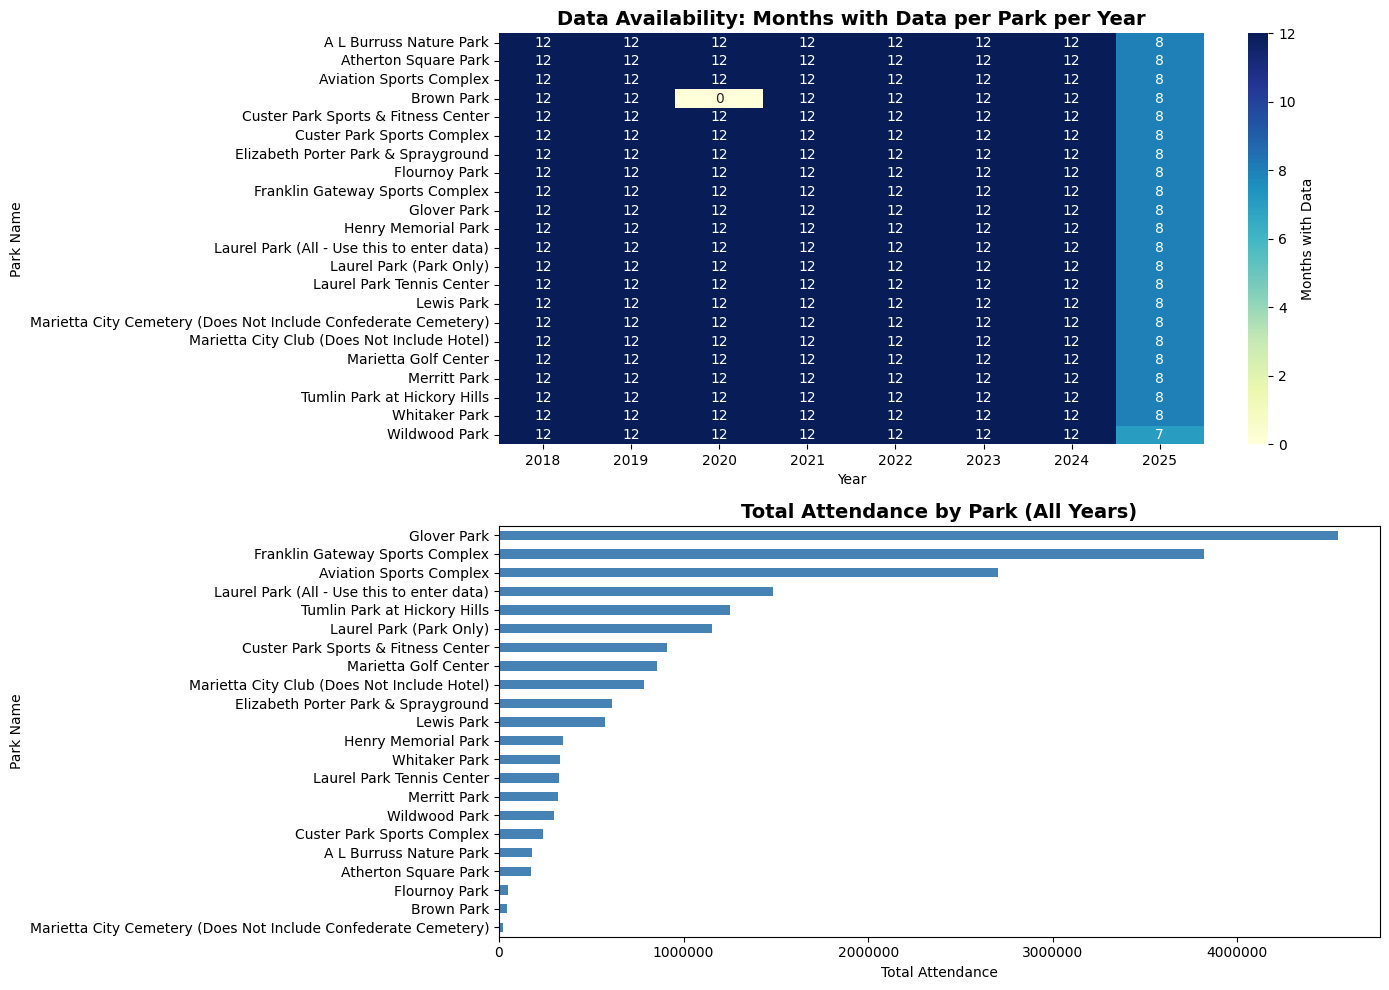

In [4]:
# Ensure 'date' is a datetime column
df['date'] = pd.to_datetime(df['date'])

# Extract year and month for grouping
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Pivot table: count months with data per park per year
pivot_data = df.groupby(['park_id', 'year'])['month'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Data availability heatmap by park and year
sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlGnBu',
            cbar_kws={'label': 'Months with Data'}, ax=axes[0])
axes[0].set_title('Data Availability: Months with Data per Park per Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Park Name')

# Plot 2: Total attendance by park
park_totals = df.groupby('park_id')['attendance'].sum().sort_values(ascending=True)
park_totals.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Total Attendance by Park (All Years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Attendance')
axes[1].set_ylabel('Park Name')
axes[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.savefig('Images/Data/data_quality_overview.png', dpi=300, bbox_inches='tight')
plt.show()


## Feature Engineering

In [5]:
df_model = df.copy()

# Ensure data is sorted
df_model = df_model.sort_values(['park_id', 'month', 'date'])

# Calculate expanding mean for each park and month, excluding the current row
def expanding_mean_exclude_current(x):
    return x.shift(1).expanding().mean()

df_model['park_month_avg_attendance'] = (
    df_model.groupby(['park_id', 'month'])['attendance']
    .transform(expanding_mean_exclude_current)
)


# Ensure that date is a datetime column
df_model['date'] = pd.to_datetime(df_model['date'])
df_model['year'] = df_model['date'].dt.year
df_model['month'] = df_model['date'].dt.month
df_model['quarter'] = df_model['date'].dt.quarter
df_model['is_summer'] = df_model['month'].isin([6, 7, 8]).astype(int)
df_model['is_winter'] = df_model['month'].isin([12, 1, 2]).astype(int)

# Encode cyclical months with sine and cosine transformations
df_model['month_sin'] = np.sin(2 * np.pi * df_model['month'] / 12)
df_model['month_cos'] = np.cos(2 * np.pi * df_model['month'] / 12)

# Sort by park and date
df_model = df_model.sort_values(['park_id', 'date'])
# Lag features (e.g., previous month, 3 months ago)
for lag in [1, 3, 6, 12]:
    df_model[f'attendance_lag_{lag}'] = df_model.groupby('park_id')['attendance'].shift(lag)

for window in [3, 6, 12]:
    df_model[f'attendance_rollmean_{window}'] = df_model.groupby('park_id')['attendance'].shift(1).rolling(window).mean()
    df_model[f'attendance_rollstd_{window}'] = df_model.groupby('park_id')['attendance'].shift(1).rolling(window).std()


# One-hot encode park_id
df_model = pd.get_dummies(df_model, columns=['park_id'])


df_model.to_csv('Data/model_data.csv', index=False)

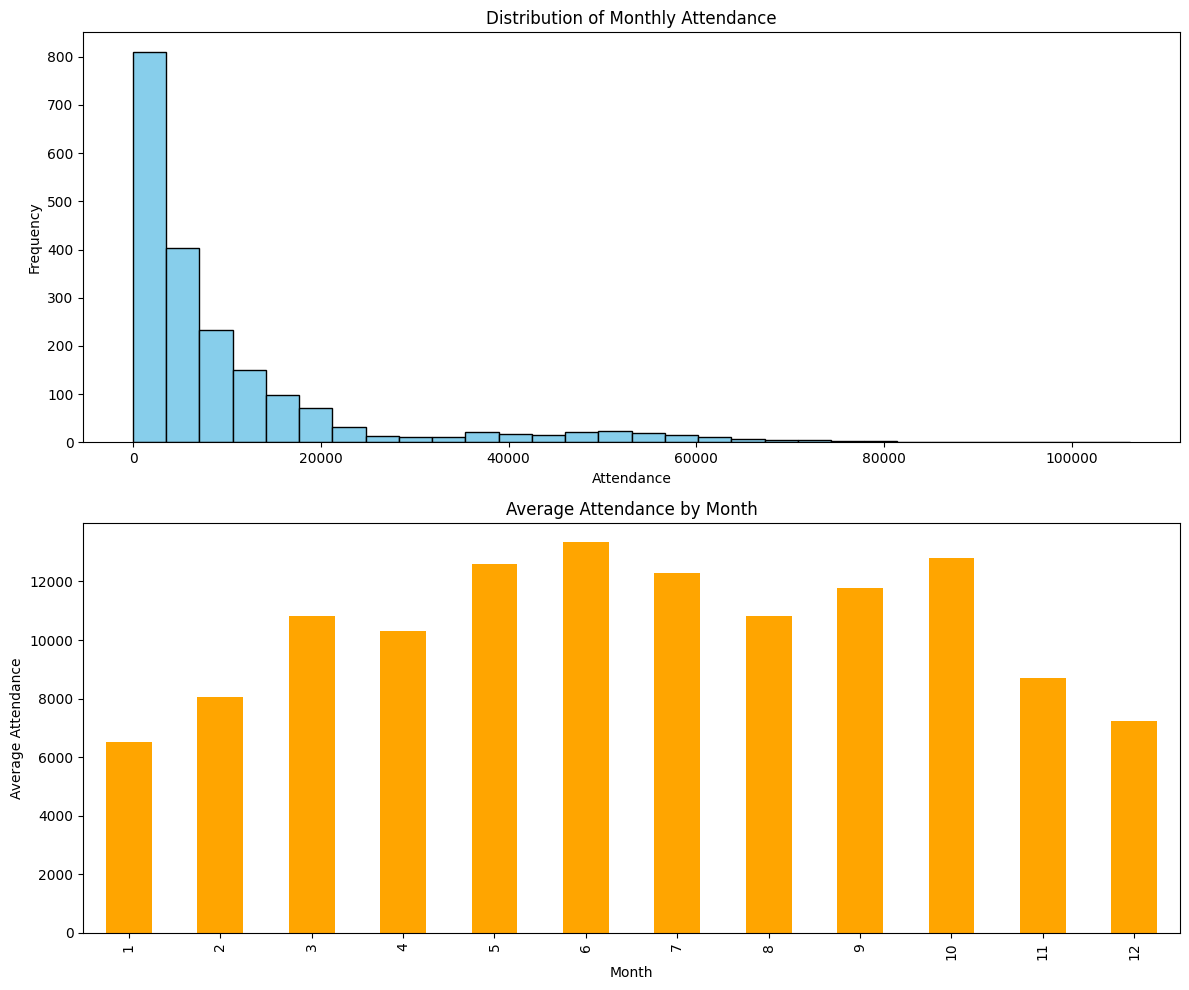

In [6]:
import matplotlib.pyplot as plt

# Calculate average attendance by month
monthly_avg = df_model.groupby('month')['attendance'].mean()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Histogram of attendance
axes[0].hist(df_model['attendance'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Monthly Attendance')
axes[0].set_xlabel('Attendance')
axes[0].set_ylabel('Frequency')

# Plot 2: Average attendance by month
monthly_avg.plot(kind='bar', color='orange', ax=axes[1])
axes[1].set_title('Average Attendance by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Attendance')

plt.tight_layout()
plt.savefig('Images/Data/data_model_monthly_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## Data Spliting

In [7]:
# Sort by date (and park if needed)
df_model = df_model.sort_values(['date'])

# Define the split point (e.g., last 12 months for testing)
split_date = df_model['date'].max() - pd.DateOffset(months=12)

# Training data: everything before the split date
train = df_model[df_model['date'] < split_date]

# Testing data: everything from the split date onward
test = df_model[df_model['date'] >= split_date]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (1726, 42)
Test shape: (285, 42)


## Hypertuning

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


## Model Development

In [9]:
# Use all engineered features except attendance as predictors
feature_cols = [col for col in train.columns if col not in ['attendance', 'date']]
X_train = train[feature_cols]
y_train = train['attendance']
X_test = test[feature_cols]
y_test = test['attendance']

# XGBoost
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    xgb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
xgb_preds = xgb_best.predict(X_test)

# LightGBM
lgb_search = RandomizedSearchCV(
    LGBMRegressor(random_state=42),
    lgb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_
lgb_preds = lgb_best.predict(X_test)

# Random Forest
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
rf_preds = rf_best.predict(X_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 578, number of used features: 40
[LightGBM] [Info] Start training from score 10371.486159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the trai

## Model Performance

In [10]:
# MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Collect metrics for each model
metrics = []
for name, preds in zip(
    ["XGBoost", "LightGBM", "Random Forest"],
    [xgb_preds, lgb_preds, rf_preds]
):
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    metrics.append([name, mae, rmse, r2, mape])

# Create and display the table
metrics_df = pd.DataFrame(metrics, columns=["Model", "MAE", "RMSE", "R²", "MAPE (%)"])
display(metrics_df)

,Model,MAE,RMSE,R²,MAPE (%)
0,XGBoost,1545.041824,3276.204475,0.935674,21.955591
1,LightGBM,1826.472478,3983.767055,0.904888,24.931783
2,Random Forest,1553.855263,3273.497400,0.935780,23.934813


## Model Evaluation

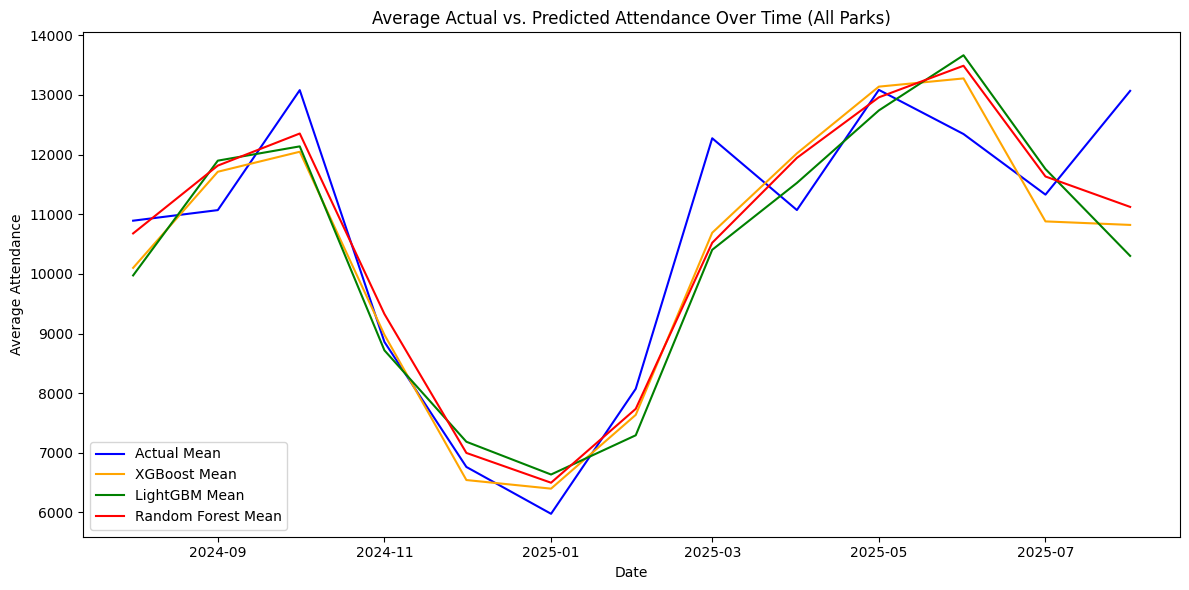

In [ ]:
# Average across parks per date
plt.figure(figsize=(12,6))
plt.plot(test['date'].unique(), test.groupby('date')['attendance'].mean(), label='Actual Mean', color='blue')
plt.plot(test['date'].unique(), pd.Series(xgb_preds, index=test.index).groupby(test['date']).mean(), label='XGBoost Mean', color='orange')
plt.plot(test['date'].unique(), pd.Series(lgb_preds, index=test.index).groupby(test['date']).mean(), label='LightGBM Mean', color='green')
plt.plot(test['date'].unique(), pd.Series(rf_preds, index=test.index).groupby(test['date']).mean(), label='Random Forest Mean', color='red')
plt.title('Average Actual vs. Predicted Attendance Over Time (All Parks)')
plt.xlabel('Date')
plt.ylabel('Average Attendance')
plt.legend()
plt.tight_layout()
plt.savefig('Images/Modeling/actual_vs_predicted_time_series.png', dpi=300, bbox_inches='tight')
plt.show()


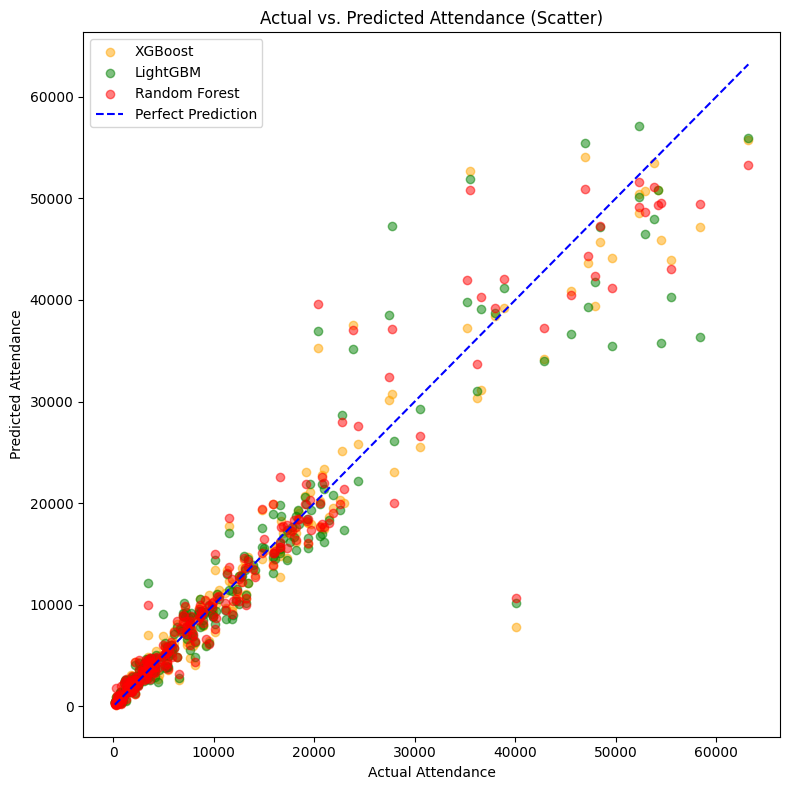

In [ ]:
# Actual vs. Predicted Attendance (Scatterplot)
plt.figure(figsize=(8,8))
plt.scatter(test['attendance'], xgb_preds, alpha=0.5, color='orange', label='XGBoost')
plt.scatter(test['attendance'], lgb_preds, alpha=0.5, color='green', label='LightGBM')
plt.scatter(test['attendance'], rf_preds, alpha=0.5, color='red', label='Random Forest')
plt.plot([test['attendance'].min(), test['attendance'].max()],
         [test['attendance'].min(), test['attendance'].max()],
         'b--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Attendance (Scatter)')
plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.legend()
plt.tight_layout()
plt.savefig('Images/Modeling/actual_vs_predicted_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


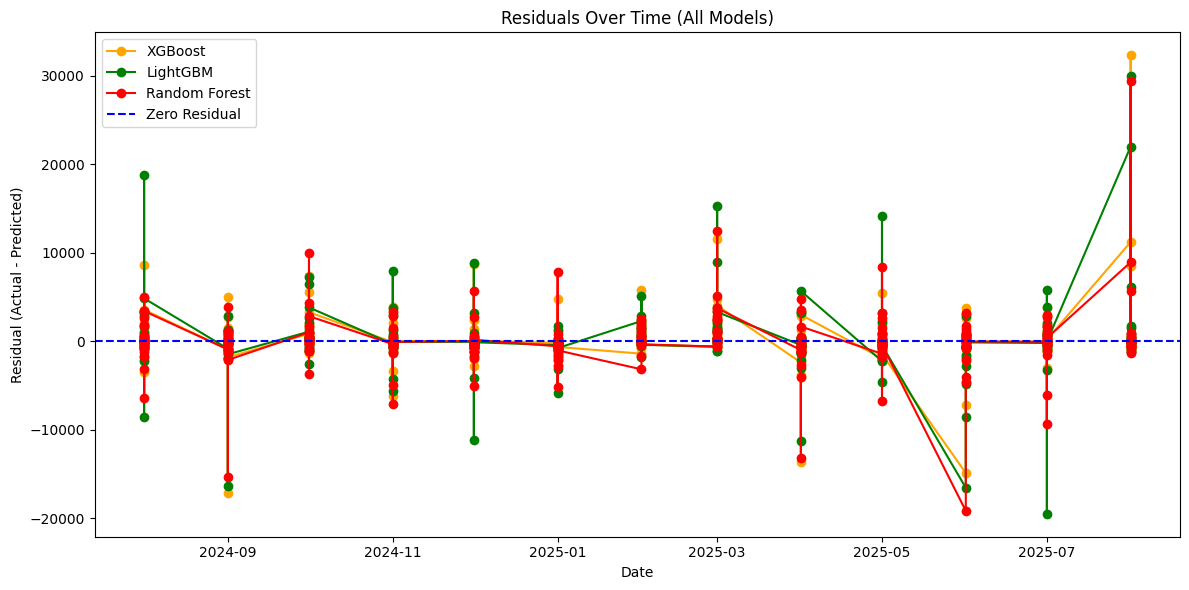

In [ ]:
plt.figure(figsize=(12,6))

# Calculate residuals for each model
residuals_xgb = y_test - xgb_preds
residuals_lgb = y_test - lgb_preds
residuals_rf = y_test - rf_preds

plt.plot(test['date'], residuals_xgb, marker='o', label='XGBoost', color='orange')
plt.plot(test['date'], residuals_lgb, marker='o', label='LightGBM', color='green')
plt.plot(test['date'], residuals_rf, marker='o', label='Random Forest', color='red')
plt.axhline(0, color='blue', linestyle='--', label='Zero Residual')
plt.title('Residuals Over Time (All Models)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.tight_layout()
plt.savefig('Images/Modeling/residuals_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


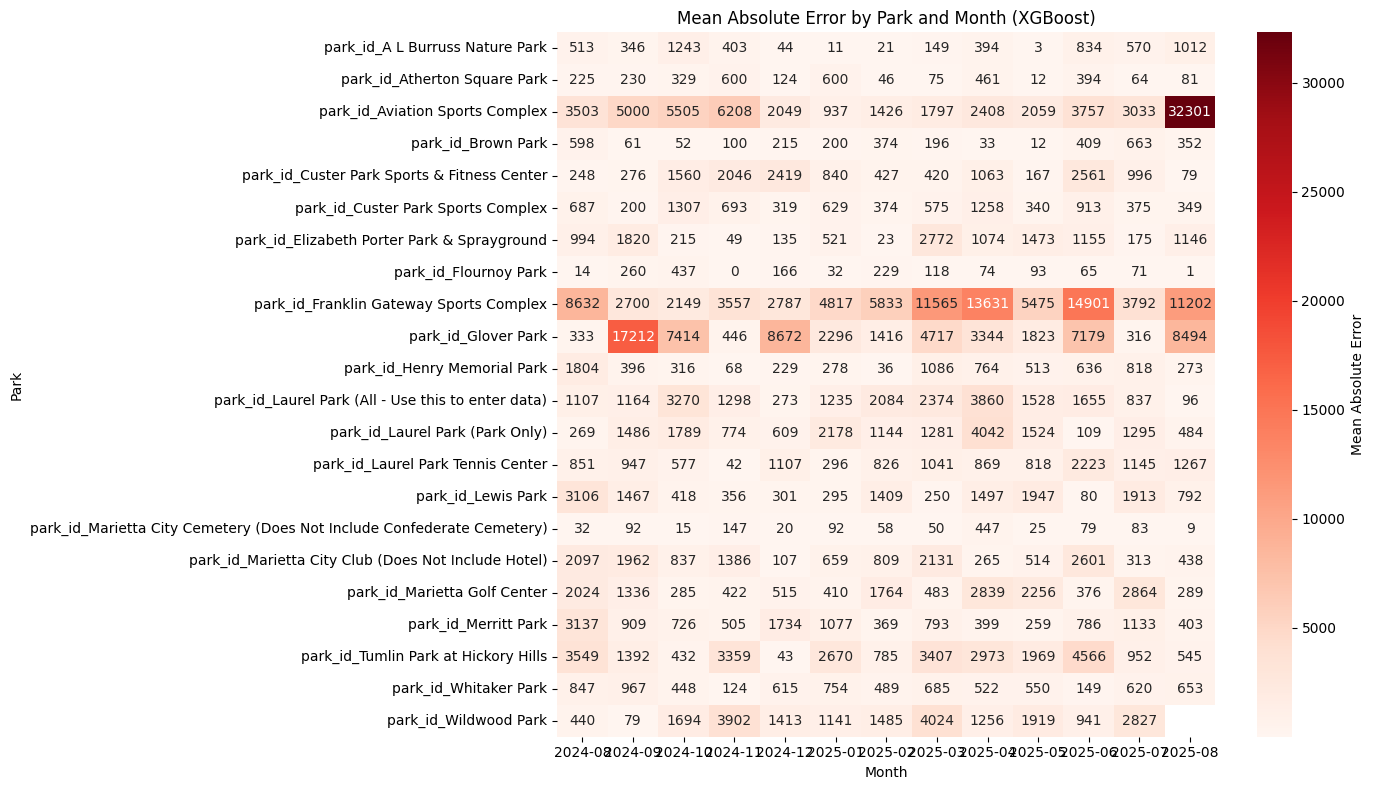

In [23]:
# Calculate absolute error for the predictions
error = np.abs(y_test - xgb_preds)

# Add errors to the test dataframe
test_with_error = test.copy()
test_with_error['abs_error'] = error

test_with_error['month'] = pd.to_datetime(test_with_error['date']).dt.strftime('%Y-%m')
park_columns = [col for col in test.columns if col.startswith('park_')]

# Melt so each row has month, park, error
melted = test_with_error.melt(
    id_vars=['month', 'abs_error'],
    value_vars=park_columns,
    var_name='park',
    value_name='is_park'
)
melted = melted[melted['is_park'] == 1]

# Pivot mean error by park and month
error_matrix = melted.pivot_table(
    index='park',
    columns='month',
    values='abs_error',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds', cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Error by Park and Month (XGBoost)')
plt.xlabel('Month')
plt.ylabel('Park')
plt.tight_layout()
plt.savefig('Images/Modeling/xgboost_mean_absolute_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


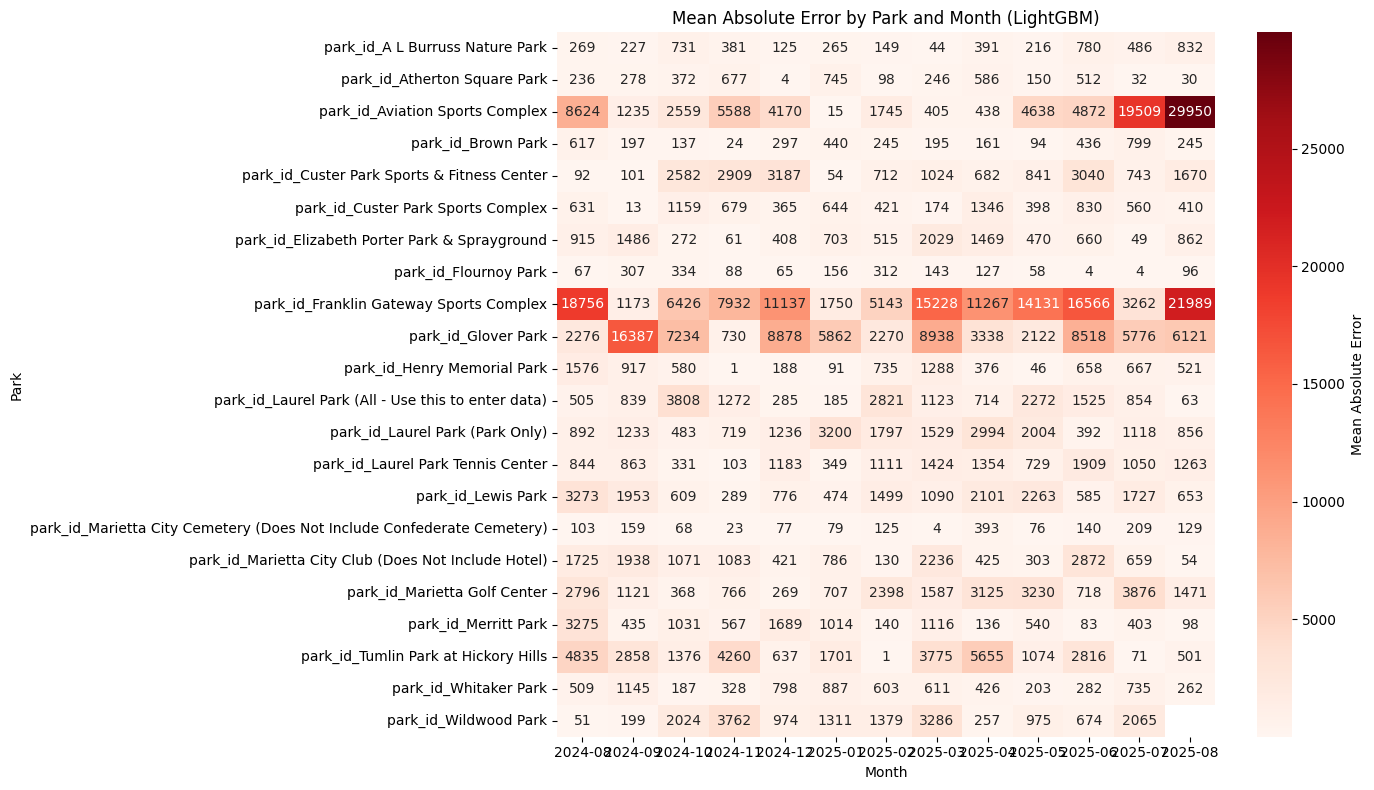

In [24]:
# Calculate absolute error for the predictions
error = np.abs(y_test - lgb_preds)

# Add errors to the test dataframe
test_with_error = test.copy()
test_with_error['abs_error'] = error

test_with_error['month'] = pd.to_datetime(test_with_error['date']).dt.strftime('%Y-%m')
park_columns = [col for col in test.columns if col.startswith('park_')]

# Melt so each row has month, park, error
melted = test_with_error.melt(
    id_vars=['month', 'abs_error'],
    value_vars=park_columns,
    var_name='park',
    value_name='is_park'
)
melted = melted[melted['is_park'] == 1]

# Pivot mean error by park and month
error_matrix = melted.pivot_table(
    index='park',
    columns='month',
    values='abs_error',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds', cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Error by Park and Month (LightGBM)')
plt.xlabel('Month')
plt.ylabel('Park')
plt.tight_layout()
plt.savefig('Images/Modeling/lightgbm_mean_absolute_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


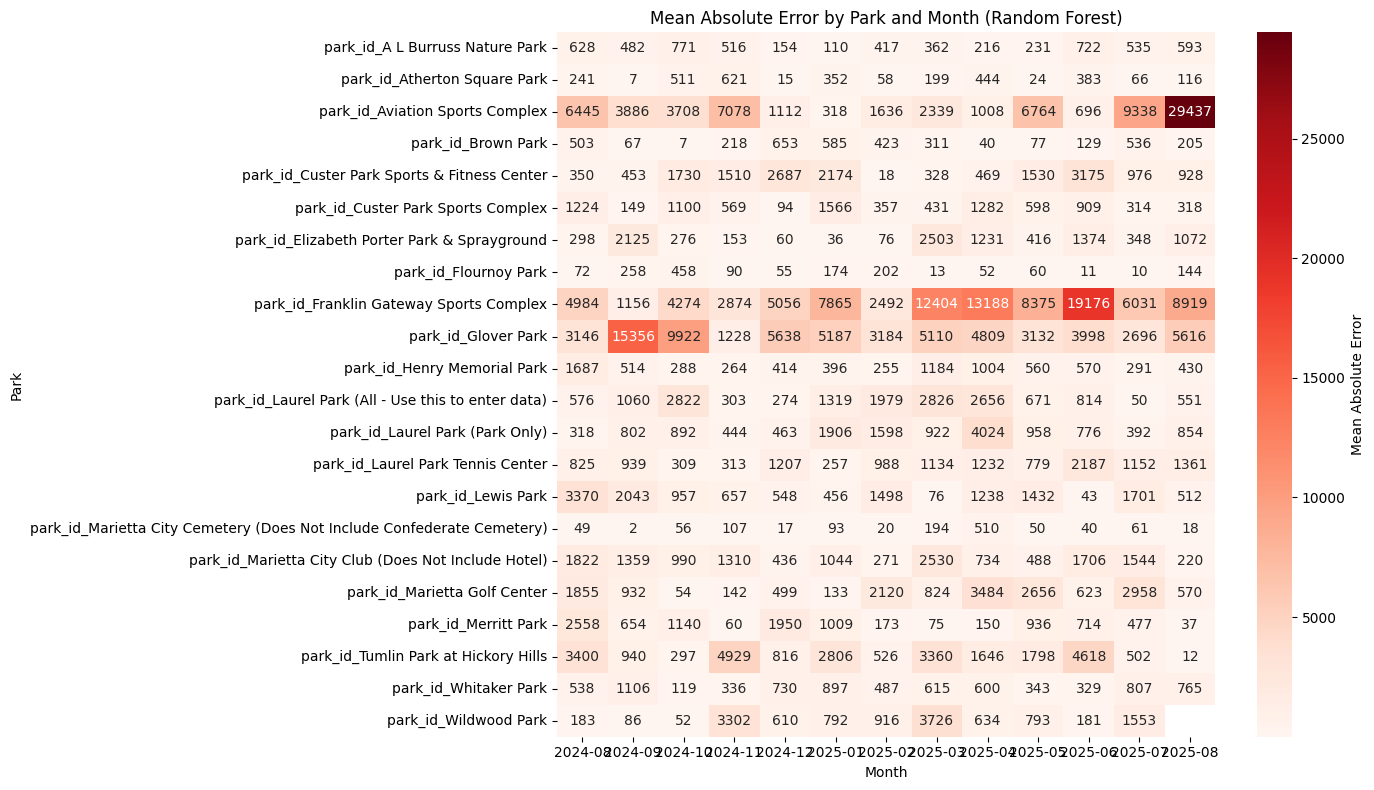

In [25]:
# Calculate absolute error for the predictions
error = np.abs(y_test - rf_preds)

# Add errors to the test dataframe
test_with_error = test.copy()
test_with_error['abs_error'] = error

test_with_error['month'] = pd.to_datetime(test_with_error['date']).dt.strftime('%Y-%m')
park_columns = [col for col in test.columns if col.startswith('park_')]

# Melt so each row has month, park, error
melted = test_with_error.melt(
    id_vars=['month', 'abs_error'],
    value_vars=park_columns,
    var_name='park',
    value_name='is_park'
)
melted = melted[melted['is_park'] == 1]

# Pivot mean error by park and month
error_matrix = melted.pivot_table(
    index='park',
    columns='month',
    values='abs_error',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds', cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Error by Park and Month (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Park')
plt.tight_layout()
plt.savefig('Images/Modeling/random_forest_mean_absolute_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## Feature Importance

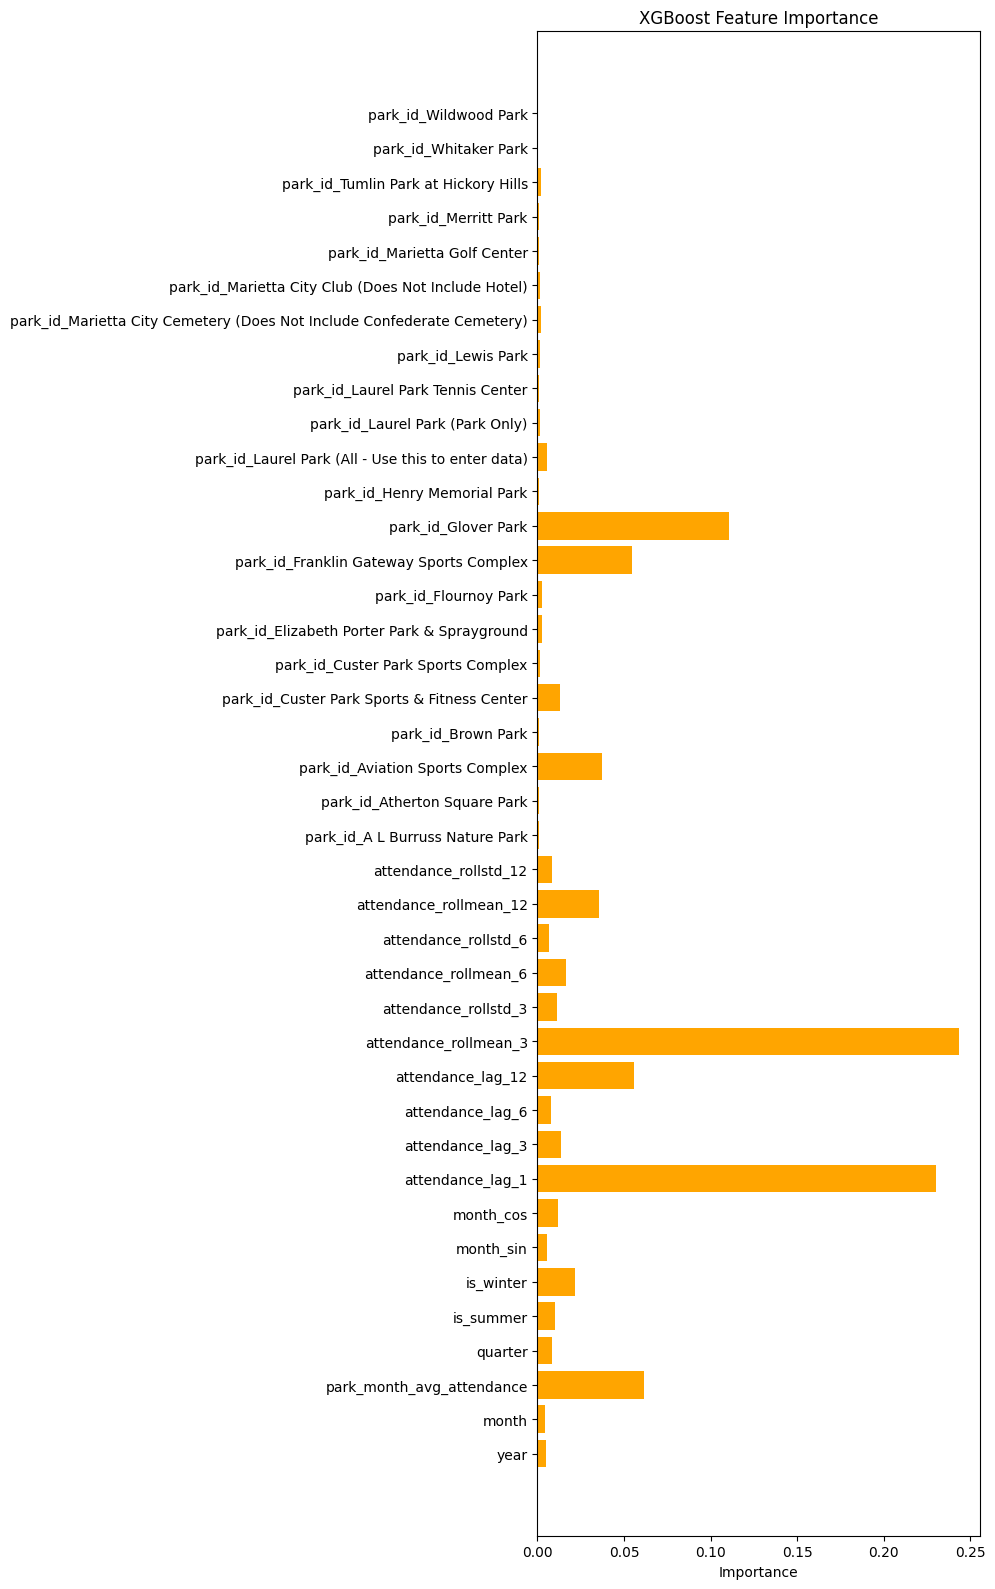

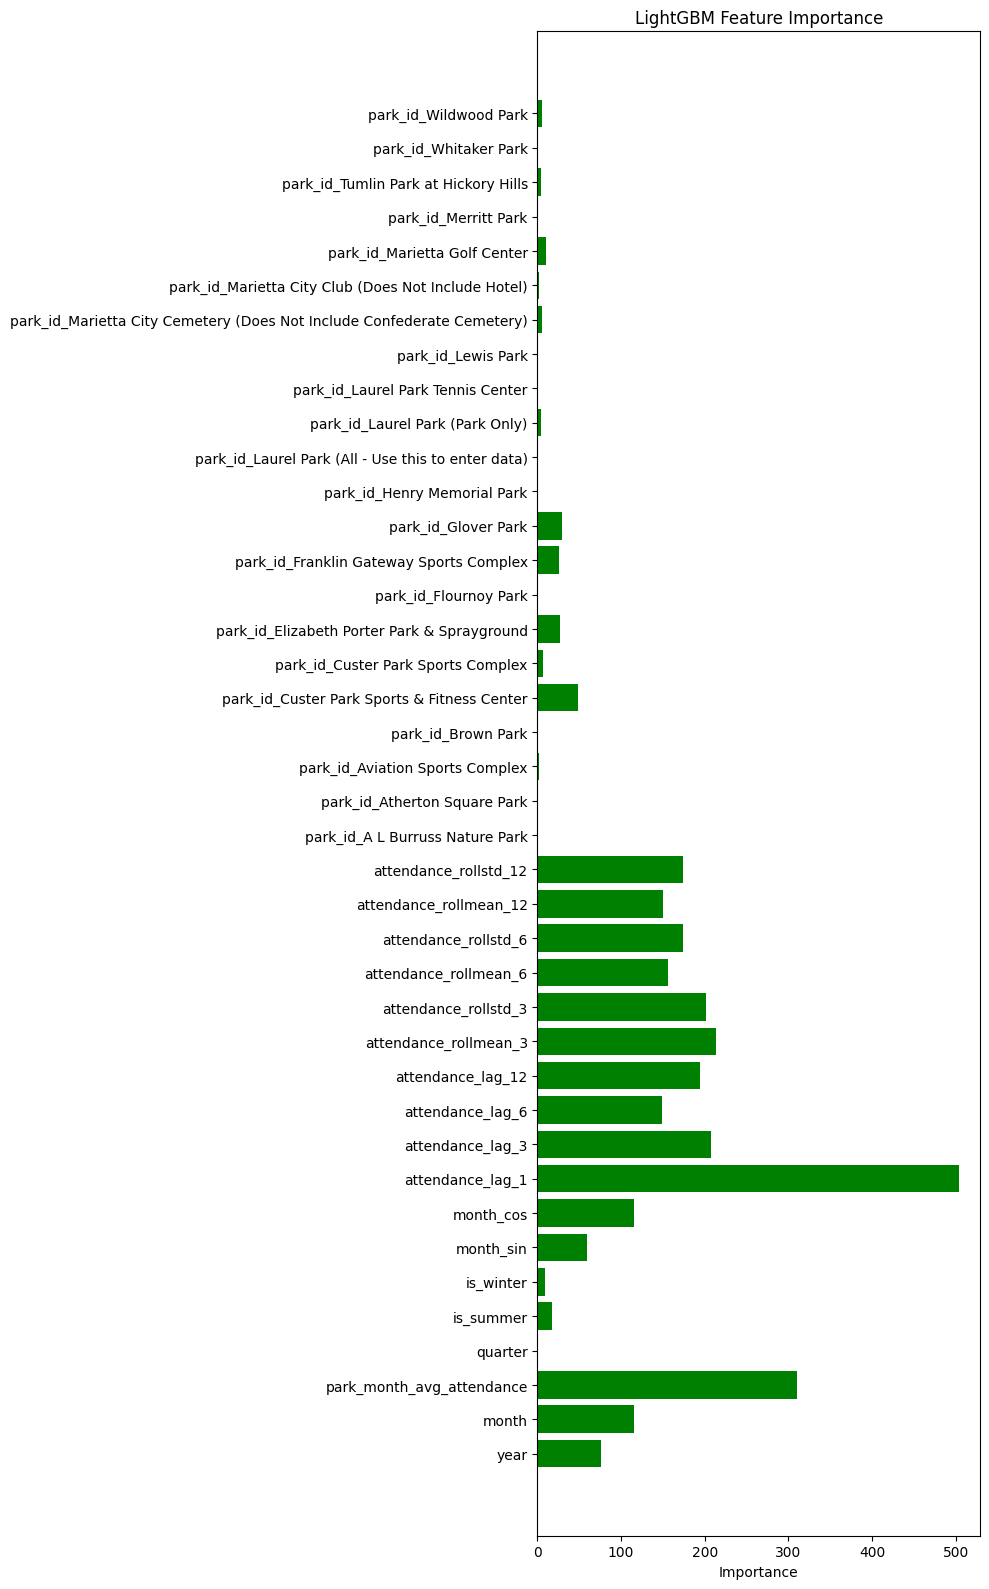

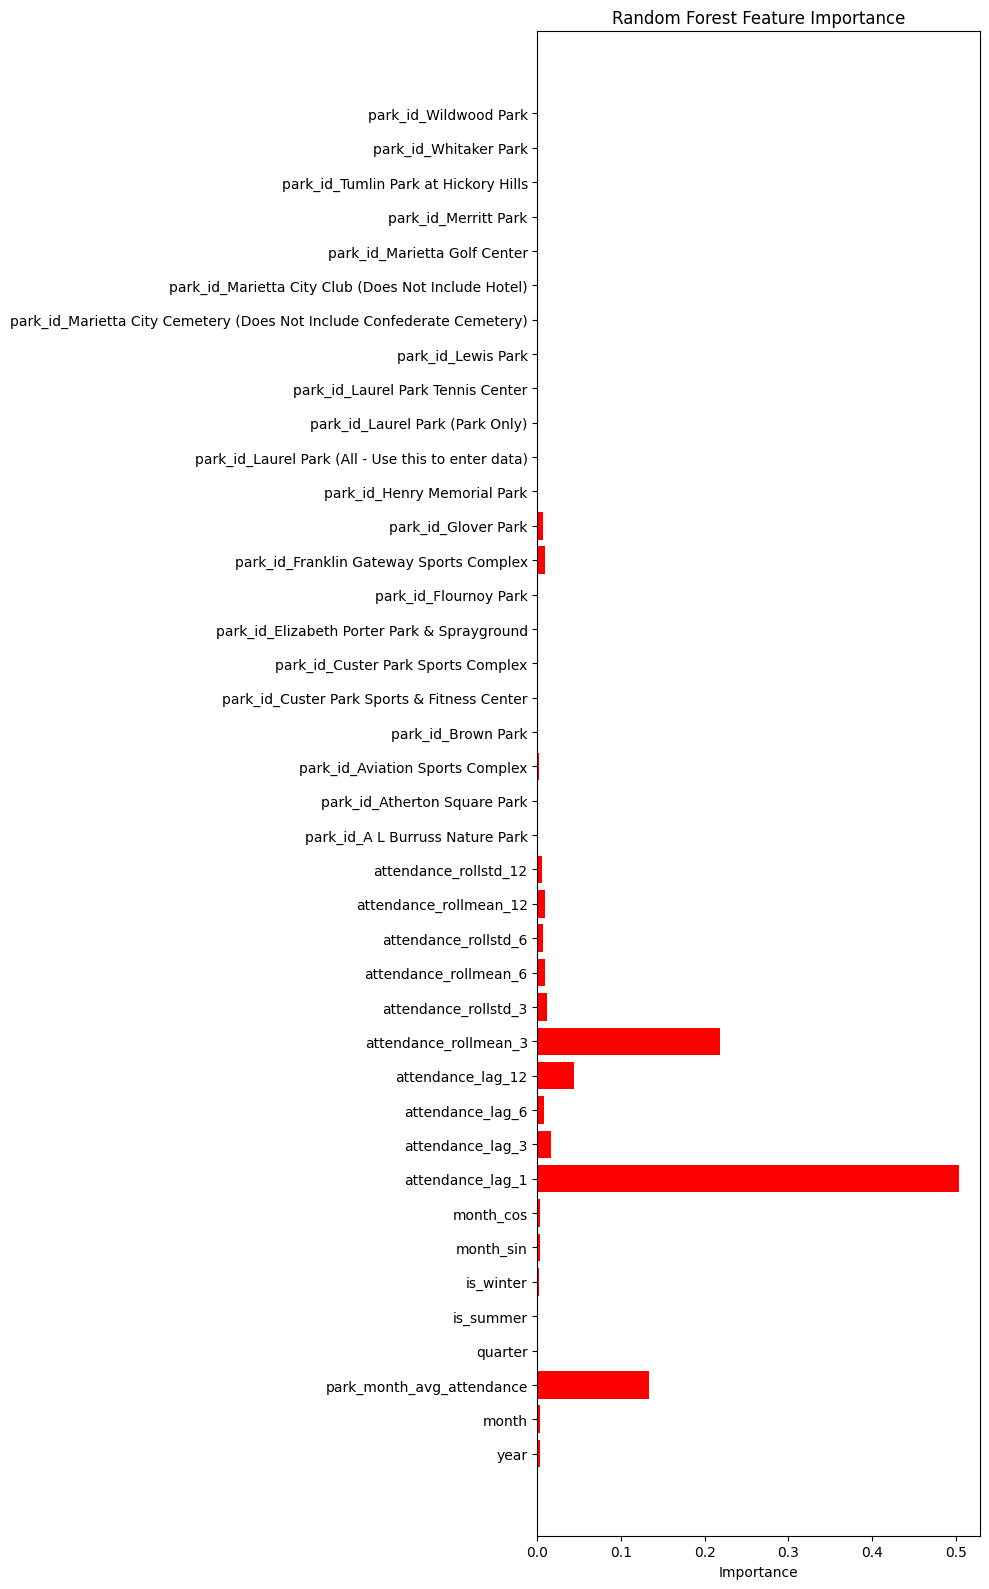

In [17]:
xgb_model = xgb_best
lgb_model = lgb_best
rf_model = rf_best

# XGBoost Feature Importance
plt.figure(figsize=(10, len(feature_cols) * 0.4))
plt.barh(feature_cols, xgb_model.feature_importances_, color='orange')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('Images/Modeling/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# LightGBM Feature Importance
plt.figure(figsize=(10, len(feature_cols) * 0.4))
plt.barh(feature_cols, lgb_model.feature_importances_, color='green')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('Images/Modeling/lightgbm_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Random Forest Feature Importance
plt.figure(figsize=(10, len(feature_cols) * 0.4))
plt.barh(feature_cols, rf_model.feature_importances_, color='red')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('Images/Modeling/randomforest_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


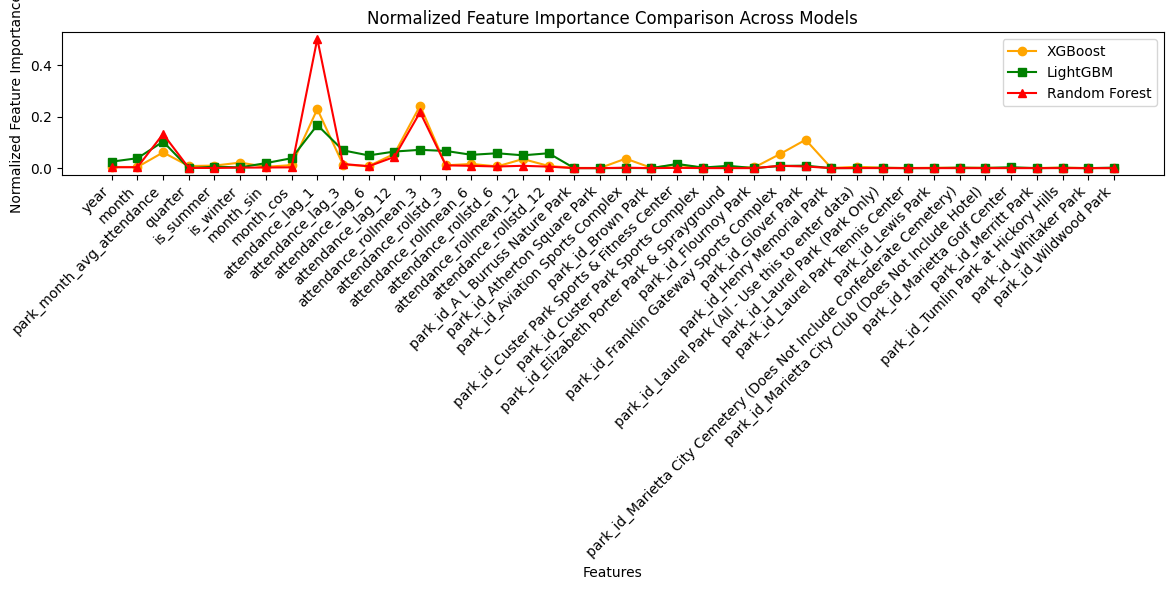

In [18]:
# Normalize importances to sum to 1 for each model
xgb_importance = xgb_model.feature_importances_ / np.sum(xgb_model.feature_importances_)
lgb_importance = lgb_model.feature_importances_ / np.sum(lgb_model.feature_importances_)
rf_importance = rf_model.feature_importances_ / np.sum(rf_model.feature_importances_)

features = feature_cols
indices = np.arange(len(features))

plt.figure(figsize=(12, 6))
plt.plot(indices, xgb_importance, marker='o', label='XGBoost', color='orange')
plt.plot(indices, lgb_importance, marker='s', label='LightGBM', color='green')
plt.plot(indices, rf_importance, marker='^', label='Random Forest', color='red')

plt.xticks(indices, features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Normalized Feature Importance')
plt.title('Normalized Feature Importance Comparison Across Models')
plt.legend()
plt.tight_layout()
plt.savefig('Images/Modeling/feature_importance_comparison_line.png', dpi=300, bbox_inches='tight')
plt.show()
